# ICA

## Different libraries and functions used for this tp ( je dois faire le tri et y a des trucs en double)

In [1]:
from scipy.stats import gamma 
from matplotlib import pyplot as plt
import numpy as np
import math
from ipywidgets import interact
import os
from nilearn import datasets

%matplotlib inline

import sys
!conda install --yes --prefix {sys.prefix} --channel conda-forge statsmodels
import nibabel as nib
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from nilearn.glm import threshold_stats_img

from nilearn.glm.first_level.design_matrix import _make_drift
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.glm.first_level.hemodynamic_models import _sample_condition, _resample_regressor, glover_hrf
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
from nilearn.plotting import plot_contrast_matrix

In [2]:
!pip install tqdm
!pip install fury
!pip install nibabel
!pip install nistats
!pip install nilearn
!pip install tensorly

In [3]:
import os
from tqdm.notebook import trange, tqdm
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from dipy.viz import regtools
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.maskers import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from tensorly.decomposition import parafac
from IPython.display import Image

save_results = 'results/'
if not os.path.exists(save_results):
    os.makedirs(save_results)
    
%matplotlib inline

In [4]:
import fsl.wrappers
import mne_nirs
import nilearn
import mne
import mne_nirs
import dipy
import xml.etree.ElementTree as ET
import os.path as op
from fsleyes.views.orthopanel import OrthoPanel
import nibabel as nib
from nilearn.datasets import fetch_development_fmri
from fsl.wrappers import fslmaths
import glob
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects

## IX - Dataset ds000171

### Récuparation dataset

In [5]:
import os.path as op
from mne.datasets import sample
# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm

def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')

In [6]:
dataset_fmap = 'ds000171'
subject_fmap = 'control01' 

# Download one subject's data from each dataset
bids_root = op.join(op.dirname(sample.data_path()), dataset_fmap)

mkdir_no_exist(bids_root)



func_path = op.join(bids_root, 'sub-control01', 'func')
mkdir_no_exist(op.join(bids_root, 'sub-control01'))
mkdir_no_exist(func_path)

direct_file_download_open_neuro(file_list=['sub-control01_task-music_run-1_events.tsv'], 
                                file_types=['func'], 
                                dataset_id=dataset_fmap, 
                                dataset_version='00001', 
                                save_dirs=[func_path])
direct_file_download_open_neuro(file_list=['sub-control01_task-music_run-1_bold.nii.gz'], 
                                file_types=['func'], 
                                dataset_id=dataset_fmap, 
                                dataset_version='00001', 
                                save_dirs=[func_path])
direct_file_download_open_neuro(file_list=['sub-control01_T1w.nii.gz'], 
                                file_types=['anat'], 
                                dataset_id=dataset_fmap, 
                                dataset_version='00001', 
                                save_dirs=[func_path])

## Informations sur le dataset

In [7]:
pd.read_csv(op.join(func_path,'sub-control01_task-music_run-1_events.tsv'), sep='\t')

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


J'ai l'impression que notre dataset n'est pas organisé comm celui du tp6, je ne l'ai pas encore implémenté mais je pense qu'il faudrait épurer les données pour ne récupérer que les images lorsque l'on est en postive/negative_music à la façon du tp6, où les données sont récupérées uniquement lorsque les sujets regardent le film. Je pense que c'est pour ça que l'on a des résultats si différents de la thèse associée à notre dataset. 

Aussi je compte travailler avec plus de données en ajoutant d'autres sujets non dépressifs

In [8]:
load(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold.nii.gz'))
IMG = op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold.nii.gz')

## J'adapte la forme des données pour qu'elles fonctionnent avec les fonctions de la correction du tp6

In [9]:
img = nib.load(IMG)
affine = nib.load(IMG).affine
data = img.get_data()
data.shape

(80, 80, 50, 105)

In [10]:
x,y,z = img.shape[:3]
N_vol = img.shape[3]
N_subj=1
N_tot=N_vol*N_subj


In [11]:
X = np.zeros((N_tot,x*y*z)) # total_timepoints(15subj*200timepoints) x voxel_num
X.shape

(105, 320000)

In [83]:
for i in range(N_tot):
    X[i,:] = data[:,:,:,i].flatten()

In [84]:
X = zscore(X, axis = 1) # across subjects
X = np.nan_to_num(X,0) # nan to 0s
print("X matrix size: ", X.shape)

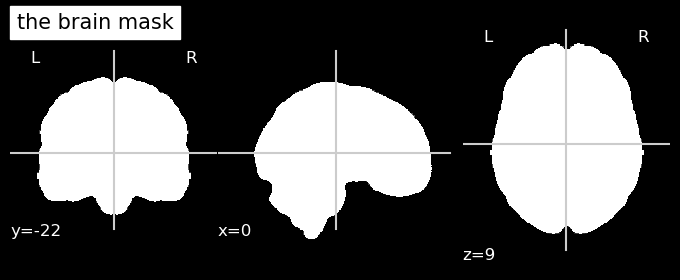

In [85]:
icbms = datasets.fetch_icbm152_2009()
masker = NiftiMasker(mask_img=icbms.mask)
plot_stat_map(icbms.mask, black_bg=True, title='the brain mask', colorbar=False,)

### Ca lance fsleyes vous visualiser les données, c'était juste un repère pour voir si j'avais corrompu des données

In [12]:
load(icbms.mask) #Ca lance fsleyes vous visualiser les données, 
load(IMG) #c'était juste un repère pour voir si j'avais corrompu des données

NameError: name 'icbms' is not defined

In [86]:
S_dict = {}

# assign the variable nb_components to be the list of components (try 3-5 values )

nb_components =  [10]

## NOTE that 60 components can be computational costly

#* We will transpose the matrix X so that ICA algorithm operates on the voxels dimension.
#* In other words, the estimated sources (S) should be have dimensionality [#voxels]


for n in nb_components:
    print(f"Processing component {n}")
    # run PCA as a preprocessing step for ICA with twice the number of components
    n2=2*n
    ### YOUR CODE HERE
    ### BEGIN SOLUTION
    pca = PCA(n_components=n2)
    H = pca.fit_transform(X.T)  # Reconstruct signals based on orthogonal components
    ### END SOLUTION
    
    # Reminder: Fast ICA model S = X W
    print("Running FastICA with n = %d components" %n)
    ### BEGIN SOLUTION
    ica = FastICA(n_components=n, random_state=1, max_iter=200)
    S_ = ica.fit_transform(H)  # Get the estimated sources (S)
    ### END SOLUTION
    print(S_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    S_dict[n] = S_ # store the results in a dictionary

In [92]:
T1w_img = nib.load(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_T1w.nii.gz'))

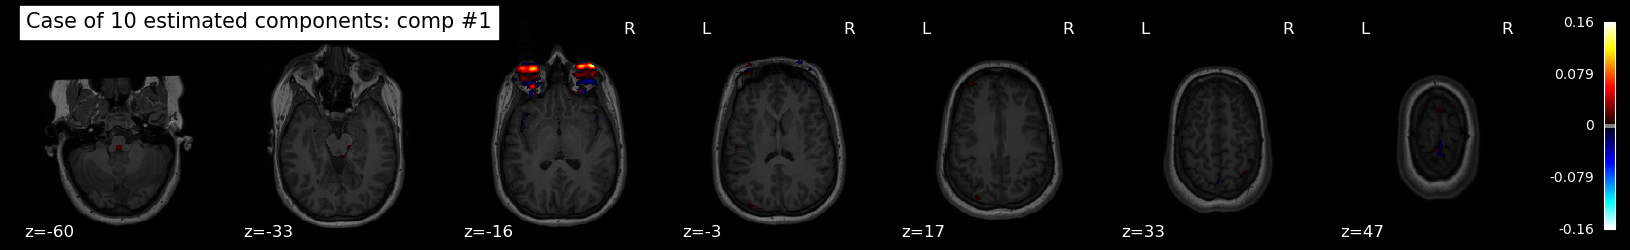

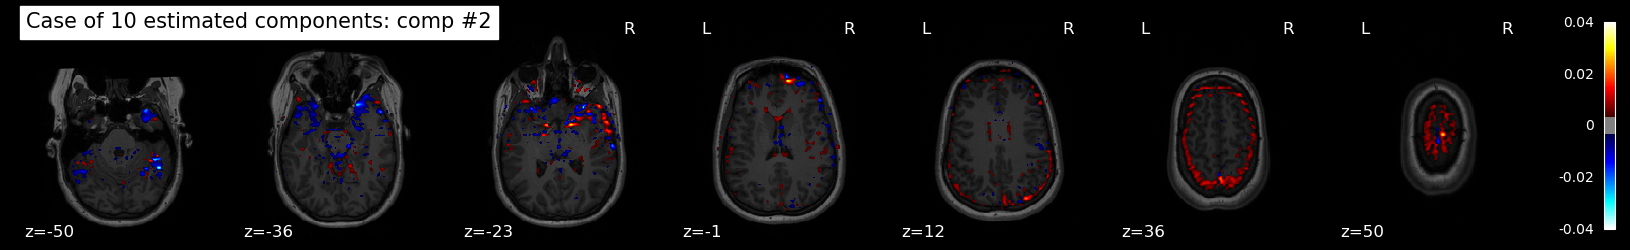

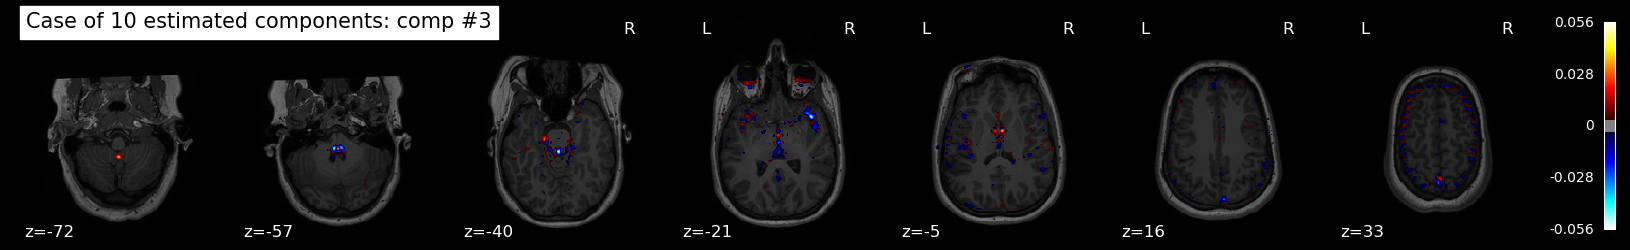

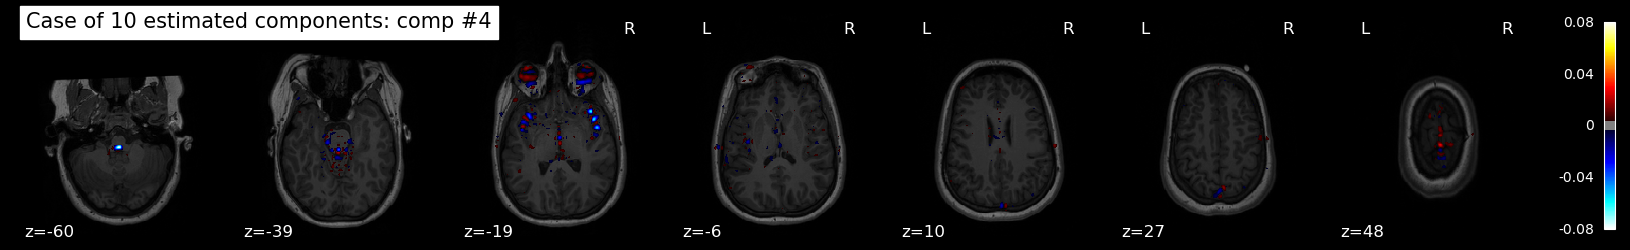

In [94]:
nb_components = nb_components[:3]

for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(4, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components , change 10 with 4 to plot less
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode="z", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img,)
                      #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()

Je suis pas sûr de ma compréhension de comp#, faut que je taffe plus sur la théorie